In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

# Asteroseismology in the time domain

This notebook show an example of fitting the asteorseismic oscillations in some time series photometry for a giant star from Kepler with a Gaussian Process model. The point of this notebook is to show that, when fitting in the time domain, it is possible to recover probabilistic estimates of $\nu_\mathrm{max}$ and $\Delta \nu$ with a shorter dataset than the one needed by the standard periodogram-based methods.

First import eveything we'll need:

In [2]:
import os
import kplr
import corner
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.ndimage.filters import gaussian_filter

import emcee3
from emcee3 import autocorr

from astropy.stats import LombScargle

import genrp
from genrp import kernels

In [3]:
def format_filename(name):
    base = os.path.join("astero", "{0}".format(kicid))
    os.makedirs(base, exist_ok=True)
    return os.path.join(base, name + ".pdf")

Now let's download the data for a giant star from

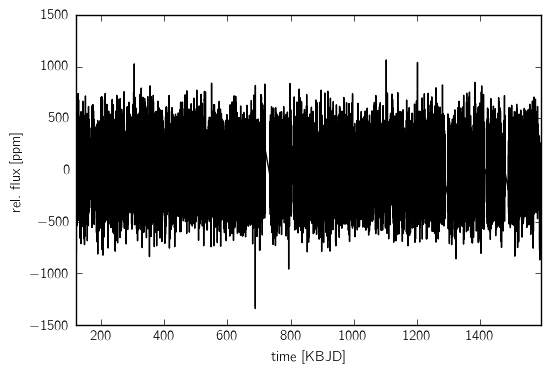

In [4]:
# kicid = 3955067
kicid = 11615890

client = kplr.API()
star = client.star(kicid)

x = []
y = []
yerr = []

for lc in star.get_light_curves():
    data = lc.read()
    x0 = data["TIME"]
    y0 = data["PDCSAP_FLUX"]
    m = (data["SAP_QUALITY"] == 0) & np.isfinite(x0) & np.isfinite(y0)
    x.append(x0[m])
    mu = np.median(y0[m])
    y.append((y0[m] / mu - 1.0) * 1e6)
    yerr.append(1e6 * data["PDCSAP_FLUX_ERR"][m] / mu)

x = np.concatenate(x)
y = np.concatenate(y)
yerr = np.concatenate(yerr)

inds = np.argsort(x)
x = np.ascontiguousarray(x[inds], dtype=float)
y = np.ascontiguousarray(y[inds], dtype=float)
yerr = np.ascontiguousarray(yerr[inds], dtype=float)

plt.plot(x, y, "k", rasterized=True)
plt.xlim(x.min(), x.max())
plt.xlabel("time [KBJD]")
plt.ylabel("rel.\ flux [ppm]")
plt.savefig(format_filename("time_series"), bbox_inches="tight", dpi=300);

Range in subset of data: 33.9 days
Fraction of full dataset: 2.7%


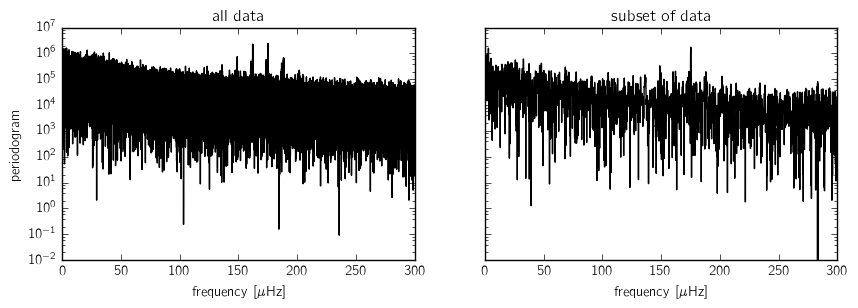

In [5]:
# Define a frequency grid for the periodogram
freq_uHz = np.linspace(1, 300, 50000)
freq = freq_uHz * 1e-6 * 24 * 60 * 60

# Compute the periodogram on the full dataset
model = LombScargle(x, y)
power_all = model.power(freq, method="fast", normalization="psd")

# Select a subset of the data
np.random.seed(1234)
n = int(30 * 48)
n0 = np.random.randint(len(x)-n-1)
fit_x, fit_y, fit_yerr = x[n0:n0+n], y[n0:n0+n], yerr[n0:n0+n]
print("Range in subset of data: {0:.1f} days".format(fit_x.max() - fit_x.min()))
print("Fraction of full dataset: {0:.1f}%".format(100 * n / len(x)))

# Compute the periodogram on the subset
model = LombScargle(fit_x, fit_y)
power_some = model.power(freq, method="fast", normalization="psd")

# Remove background from periodograms
def estimate_background(x, y, log_width=0.005):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count
bkg_all = estimate_background(freq_uHz, power_all)
bkg_some = estimate_background(freq_uHz, power_some)

# Plot the periodograms
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
axes[0].plot(freq_uHz, power_all, "k", rasterized=True)
axes[1].plot(freq_uHz, power_some, "k", rasterized=True)
axes[0].set_ylabel("periodogram")
axes[0].set_xlabel("frequency [$\mu$Hz]")
axes[1].set_xlabel("frequency [$\mu$Hz]")
axes[0].set_title("all data")
axes[1].set_title("subset of data")
[ax.set_yscale("log") for ax in axes];
fig.savefig(format_filename("periodogram"), bbox_inches="tight", dpi=300)

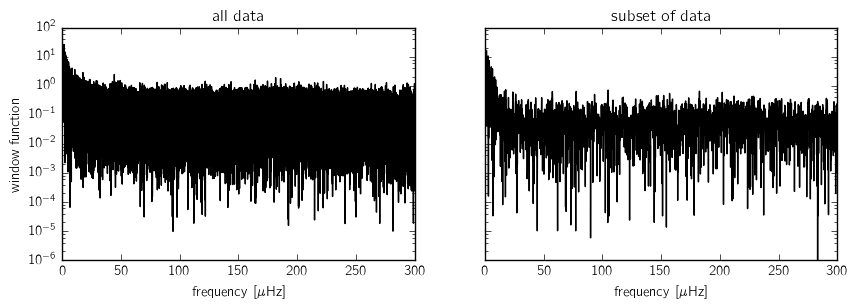

In [6]:
model = LombScargle(x, np.ones_like(y), fit_mean=False, center_data=False)
window_all = model.power(freq, method="fast", normalization="psd")
model = LombScargle(fit_x, np.ones_like(fit_y), fit_mean=False, center_data=False)
window_some = model.power(freq, method="fast", normalization="psd")

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
axes[0].plot(freq_uHz, window_all, "k", rasterized=True)
axes[1].plot(freq_uHz, window_some, "k", rasterized=True)
axes[0].set_ylabel("window function")
axes[0].set_xlabel("frequency [$\mu$Hz]")
axes[1].set_xlabel("frequency [$\mu$Hz]")
axes[0].set_title("all data")
axes[1].set_title("subset of data")
[ax.set_yscale("log") for ax in axes];
fig.savefig(format_filename("window_function"), bbox_inches="tight", dpi=300)

Compute $\nu_\mathrm{max}$ and $\Delta \nu$ from the full dataset

subset of data: nu_max = 175.03344066881337, delta_nu = 12.946958939178867
all data: nu_max = 172.18690373807476, delta_nu = 13.126362527250631


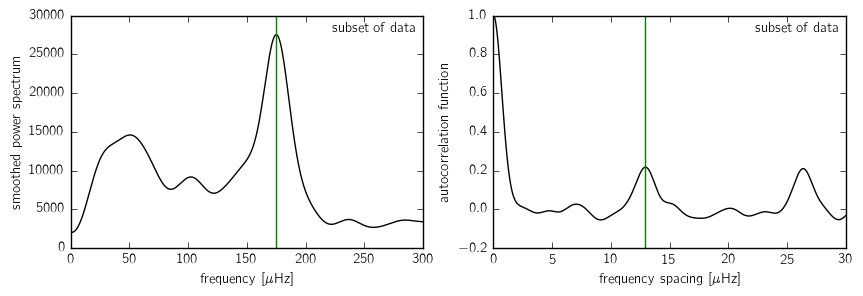

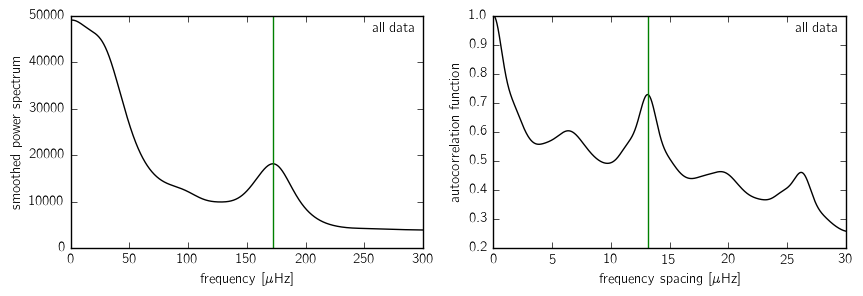

In [7]:
for name, ps in zip(("subset of data", "all data"), (power_some-bkg_some, power_all-bkg_all)):
    # Compute the smoothed power spectrum
    df = freq_uHz[1] - freq_uHz[0]
    smoothed_ps = gaussian_filter(ps, 10 / df)

    # And the autocorrelation function of a lightly smoothed power spectrum
    acor_func = autocorr.function(gaussian_filter(ps, 0.5 / df))
    lags = df*np.arange(len(acor_func))
    acor_func = acor_func[lags < 30]
    lags = lags[lags < 30]

    # Find the peaks
    def find_peaks(z):
        peak_inds = (z[1:-1] > z[:-2]) * (z[1:-1] > z[2:])
        peak_inds = np.arange(1, len(z)-1)[peak_inds]
        peak_inds = peak_inds[np.argsort(z[peak_inds])][::-1]
        return peak_inds

    peak_freqs = freq_uHz[find_peaks(smoothed_ps)]
    nu_max = peak_freqs[peak_freqs > 5][0]
    
    # Expected delta_nu: Stello et al (2009)
    dnu_expected = 0.263 * nu_max ** 0.772
    peak_lags = lags[find_peaks(acor_func)]
    delta_nu = peak_lags[np.argmin(np.abs(peak_lags - dnu_expected))]
    print("{0}: nu_max = {1}, delta_nu = {2}".format(name, nu_max, delta_nu))

    # Plot the smoothed power spectrum and autocorrelation function
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].plot(freq_uHz, smoothed_ps, "k")
    axes[0].axvline(nu_max, color="g")
    axes[0].set_ylabel("smoothed power spectrum")
    axes[0].set_xlabel("frequency [$\mu$Hz]")

    axes[1].plot(lags, acor_func, "k")
    axes[1].axvline(delta_nu, color="g")
    axes[1].set_ylabel("autocorrelation function")
    axes[1].set_xlabel("frequency spacing [$\mu$Hz]")
    axes[1].set_xlim(0, 30)
    
    for ax in axes:
        ax.annotate(name, xy=(1, 1), xycoords="axes fraction",
                    xytext=(-5, -5), textcoords="offset points",
                    ha="right", va="top")
    
    fig.savefig(format_filename("numax_deltanu_"+name.split()[0]), bbox_inches="tight")

Set up the Gaussian Process model and find the maximum likelihood parameters:

In [70]:
uHz_conv = 1e-6 * 24 * 60 * 60
p0 = np.concatenate((
    [2.0*np.log(np.median(np.abs(np.diff(fit_y)))), 5.0, 2.0],
    [
        np.log(nu_max*uHz_conv),        # log(nu_max)
        np.log(delta_nu*uHz_conv),      # log(delta_nu)
        9.0,                            # log(amp_max)
        0.0,                            # offset between nu_max and central freq. spike
        np.log(delta_nu*uHz_conv),      # width of envelope
        5.0                             # log(q_factor)
    ]
))

# A helper function for building the GP model given some parameters
def build_gp(params, nmodes=2):
    # Extract the parameters
    log_white_noise = params[0]  # unused in this function - see the likelihood function
    real_params = params[1:3]
    osc_params = params[3:]
    
    # Set up the non-periodic component
    kernel = kernels.SHOTerm(real_params[0], -0.5*np.log(2.0), real_params[1])
    # kernels.RealTerm(np.exp(real_params[0]), real_params[1])

    # Add the frequency comb
    log_nu_max, log_delta_nu, log_amp, delta_nu0, log_sigma, log_q = osc_params
    freqs = np.exp(log_nu_max) + delta_nu0 + np.exp(log_delta_nu)*np.arange(-nmodes, nmodes+1, 1)
    log_amps = log_amp - 0.5*(freqs - np.exp(log_nu_max))**2 * np.exp(-log_sigma)
    for log_a, f in zip(log_amps, freqs):
        kernel += kernels.SHOTerm(log_a - 2.0*log_q, log_q, np.log(2.0*np.pi*f))
        
    gp = genrp.GP(kernel, log_white_noise=params[0])

    return gp

# Set up some default bounds for the initial optimization
bounds = np.array([(None, None) for _ in range(len(p0))])
bounds[3] = (p0[3]-0.1, p0[3]+0.1)
bounds[4] = (p0[4]-0.1, p0[4]+0.1)

# A regularized negative log likelihood function
params = np.array(p0)
param_mask = np.ones(len(p0), dtype=bool)
def nll(p):
    params[param_mask] = p
    gp = build_gp(params)
    try:
        gp.compute(fit_x, fit_yerr)
    except (np.linalg.LinAlgError, ZeroDivisionError) as e:
        return 1e10
    ll = gp.log_likelihood(fit_y)
    if not np.isfinite(ll):
        return 1e10
    return -ll + 0.5*params[6]**2  # Regularize delta_nu_max_0 towards 0

# Maximimize the non-periodic components
param_mask[:] = False
param_mask[:3] = True
r = minimize(nll, params[param_mask], method="L-BFGS-B")
params[param_mask] = r.x
print(r.success, r.fun, np.exp(params[3:5])/uHz_conv)

# Grid initialize
param_mask[:] = True
# param_mask[6] = False
params0 = np.array(params)
best = (np.inf, np.array(params))
for lnmx in params[3] + np.linspace(-0.05, 0.05, 5):
    params = np.array(params0)
    params[3] = lnmx
    params[4] = np.log(0.263 * (np.exp(lnmx)/uHz_conv) ** 0.772 * uHz_conv)
    r = minimize(nll, params[param_mask], method="L-BFGS-B", bounds=bounds[param_mask])
    params[param_mask] = r.x
    print(r.success, r.fun, np.exp(params[3:5])/uHz_conv)
    if r.fun < best[0]:
        best = (r.fun, params)
params = best[1]

# Maximimize the non-periodic components
param_mask[:] = False
param_mask[8] = True
r = minimize(nll, params[param_mask], method="L-BFGS-B")
params[param_mask] = r.x
print(r.success, r.fun, np.exp(params[3:5])/uHz_conv)

# # Maximize all the things
# param_mask[:] = True
# r = minimize(nll, params[param_mask], method="L-BFGS-B")
# params[param_mask] = r.x
# print(r.success, r.fun, np.exp(params[3:5])/uHz_conv)

gp = build_gp(params)
print()
print("Maximum likelihood: nu_max = {0}, delta_nu = {1}"
      .format(np.exp(params[3])/uHz_conv, np.exp(params[4])/uHz_conv))

True 9523.75800955 [ 172.18690374   13.12636253]
True 9416.79544678 [ 164.22676764   13.00982704]
True 9438.73889017 [ 173.76899799   13.27026039]
True 9419.61320909 [ 168.24960239   13.1816931 ]
True 9419.81689631 [ 168.21103506   13.17855597]
True 9419.82230795 [ 169.77036884   13.18020959]
True 9416.79376554 [ 164.22676764   13.00982704]

Maximum likelihood: nu_max = 164.22676764152695, delta_nu = 13.009827035895782


In [71]:
params

array([ 8.61975724,  7.30817109,  3.49654282,  2.6524806 ,  0.11693739,
        8.73996887, -0.18074127,  0.80322143,  5.97911605])

In [72]:
p0

array([ 9.84389275,  5.        ,  2.        ,  2.69981293,  0.12585501,
        9.        ,  0.        ,  0.12585501,  5.        ])

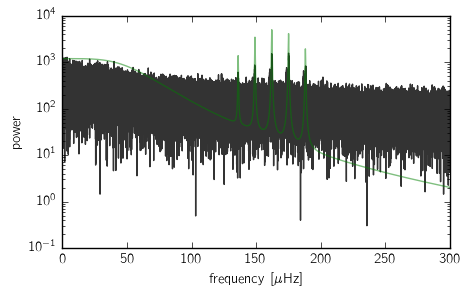

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3), sharey=True)
ax.plot(freq_uHz, np.sqrt(power_all), "k", alpha=0.8)
ax.plot(freq_uHz, gp.get_kernel_psd(2*np.pi*freq), "g", alpha=0.5)
ax.set_xlabel("frequency [$\mu$Hz]")
ax.set_ylabel("power")
ax.set_yscale("log")
fig.savefig(format_filename("intial_psd"), bbox_inches="tight")

In [74]:
def lnprob(p):
    if np.any(p[:6] < -15.0) or np.any(p[:6] > 15.0):
        return -np.inf
    if np.any(p[7:] < -15.0) or np.any(p[7:] > 15.0):
        return -np.inf
    gp = build_gp(p)
    gp.compute(fit_x, fit_yerr)
    ll = gp.log_likelihood(fit_y)
    if not np.isfinite(ll):
        return -np.inf
    return ll - 0.5 * p[6]**2

param_mask[:] = True
ndim, nwalkers = len(params), 100
initial_samples = params + 1e-5 * np.random.randn(nwalkers, ndim)

In [75]:
def astero_move(rng, x0):
    x = np.array(x0)
    f = 2.0 * (rng.rand(len(x)) < 0.5) - 1.0
    x[:, 3] = np.log(np.exp(x[:, 3]) + f * np.exp(x[:, 4]))
    return x, np.zeros(len(x))

In [76]:
sampler = emcee3.Sampler([
    emcee3.moves.StretchMove(),
    emcee3.moves.KDEMove(),
    emcee3.moves.MHMove(astero_move),
    emcee3.moves.KDEMove(),
])

In [ ]:
ensemble = emcee3.Ensemble(emcee3.SimpleModel(lnprob), initial_samples)

In [ ]:
ensemble = sampler.run(ensemble, 1000, progress=True)

 15%|█▌        | 151/1000 [08:42<47:44,  0.30it/s]

In [ ]:
plt.plot(sampler.get_coords(discard=500)[:, :, 0], color="k", alpha=0.3);

In [ ]:
autocorr.integrated_time(np.mean(sampler.get_coords(discard=100), axis=1), c=1)

In [ ]:
time_grid = np.linspace(0, 1.4, 5000)
psds = []
acors = []
samples = sampler.get_coords(discard=500, flat=True)
for s in samples[np.random.randint(len(samples), size=1000)]:
    gp = build_gp(s)
    psds.append(gp.get_kernel_psd(2*np.pi*freq))
    acors.append(gp.get_kernel_value(time_grid))

In [ ]:
q = np.percentile(acors, [16, 50, 84], axis=0)
plt.fill_between(time_grid * 24, q[0], q[2], color="k", alpha=0.3)
plt.plot(time_grid * 24, q[1], "k", alpha=0.8)
plt.xlabel(r"$\tau$ [hours]")
plt.ylabel(r"$C(\tau)$")
plt.savefig(format_filename("acor"), bbox_inches="tight")

In [ ]:
q = np.percentile(psds, [16, 50, 84], axis=0)
plt.fill_between(freq_uHz, q[0], q[2], color="k", alpha=0.3)
plt.plot(freq_uHz, q[1], "k", alpha=0.8)
plt.yscale("log")

In [ ]:
s = np.exp(samples[:, 3:5])/uHz_conv
nu_max_pub = 171.94, 3.62
delta_nu_pub = 13.28, 0.29
fig = corner.corner(s, smooth=0.7, smooth1d=1.0);
fig.axes[2].errorbar(nu_max_pub[0], delta_nu_pub[0], xerr=nu_max_pub[1], yerr=delta_nu_pub[1],
                     fmt=".", color="r", capsize=0, lw=2, mec="none")
fig.savefig(format_filename("numax_deltanu_corner"), bbox_inches="tight")

In [ ]:
corner.corner(samples);

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(5, 8))

axes[0].plot(freq_uHz, np.sqrt(power_all), "k", alpha=0.3)
axes[0].plot(freq_uHz, np.sqrt(gaussian_filter(power_all, 5)), "k")

axes[1].plot(freq_uHz, np.sqrt(power_some), "k", alpha=0.3)
axes[1].plot(freq_uHz, np.sqrt(gaussian_filter(power_some, 5)), "k")

q = np.percentile(psds, [16, 50, 84], axis=0)
axes[2].fill_between(freq_uHz, q[0], q[2], color="k", alpha=0.3)
axes[2].plot(freq_uHz, q[1], "k", alpha=0.8)

for ax in axes:
    ax.set_yscale("log")

frac = 100 * len(fit_x) / len(x)
axes[0].set_ylabel("periodogram; all data")
axes[1].set_ylabel("periodogram; {0:.0f}\% of data".format(frac))
axes[2].set_ylabel("posterior psd; {0:.0f}\% of data".format(frac))
axes[2].set_xlabel("frequency [$\mu$Hz]")

fig.savefig(format_filename("comparisons"), bbox_inches="tight")

In [161]:
!open .